In [129]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm
import os
import glob
import cv2
from PIL import Image
import pandas as pd

In [128]:
seed = 42
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
gpu_name = torch.cuda.get_device_name(device)
print(f"GPU Name: {gpu_name}")

Using device cuda:0
GPU Name: NVIDIA GeForce RTX 4090


In [3]:
torch.cuda.empty_cache()

print(torch.cuda.memory_summary())
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
from torchvision.models.segmentation import deeplabv3_resnet50

In [7]:
from datasets import load_dataset

# Specify the directory where you want to cache the dataset files
cache_directory = "/media/adminnio/Volume/Data/HuggingFace"

ds = load_dataset("EPFL-ECEO/coralscapes", cache_dir=cache_directory)


In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1517
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 166
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 392
    })
})

In [9]:
from IPython.display import display
imageA_dict = ds['train'][0]['image']
imageB_dict = ds['train'][0]['label']

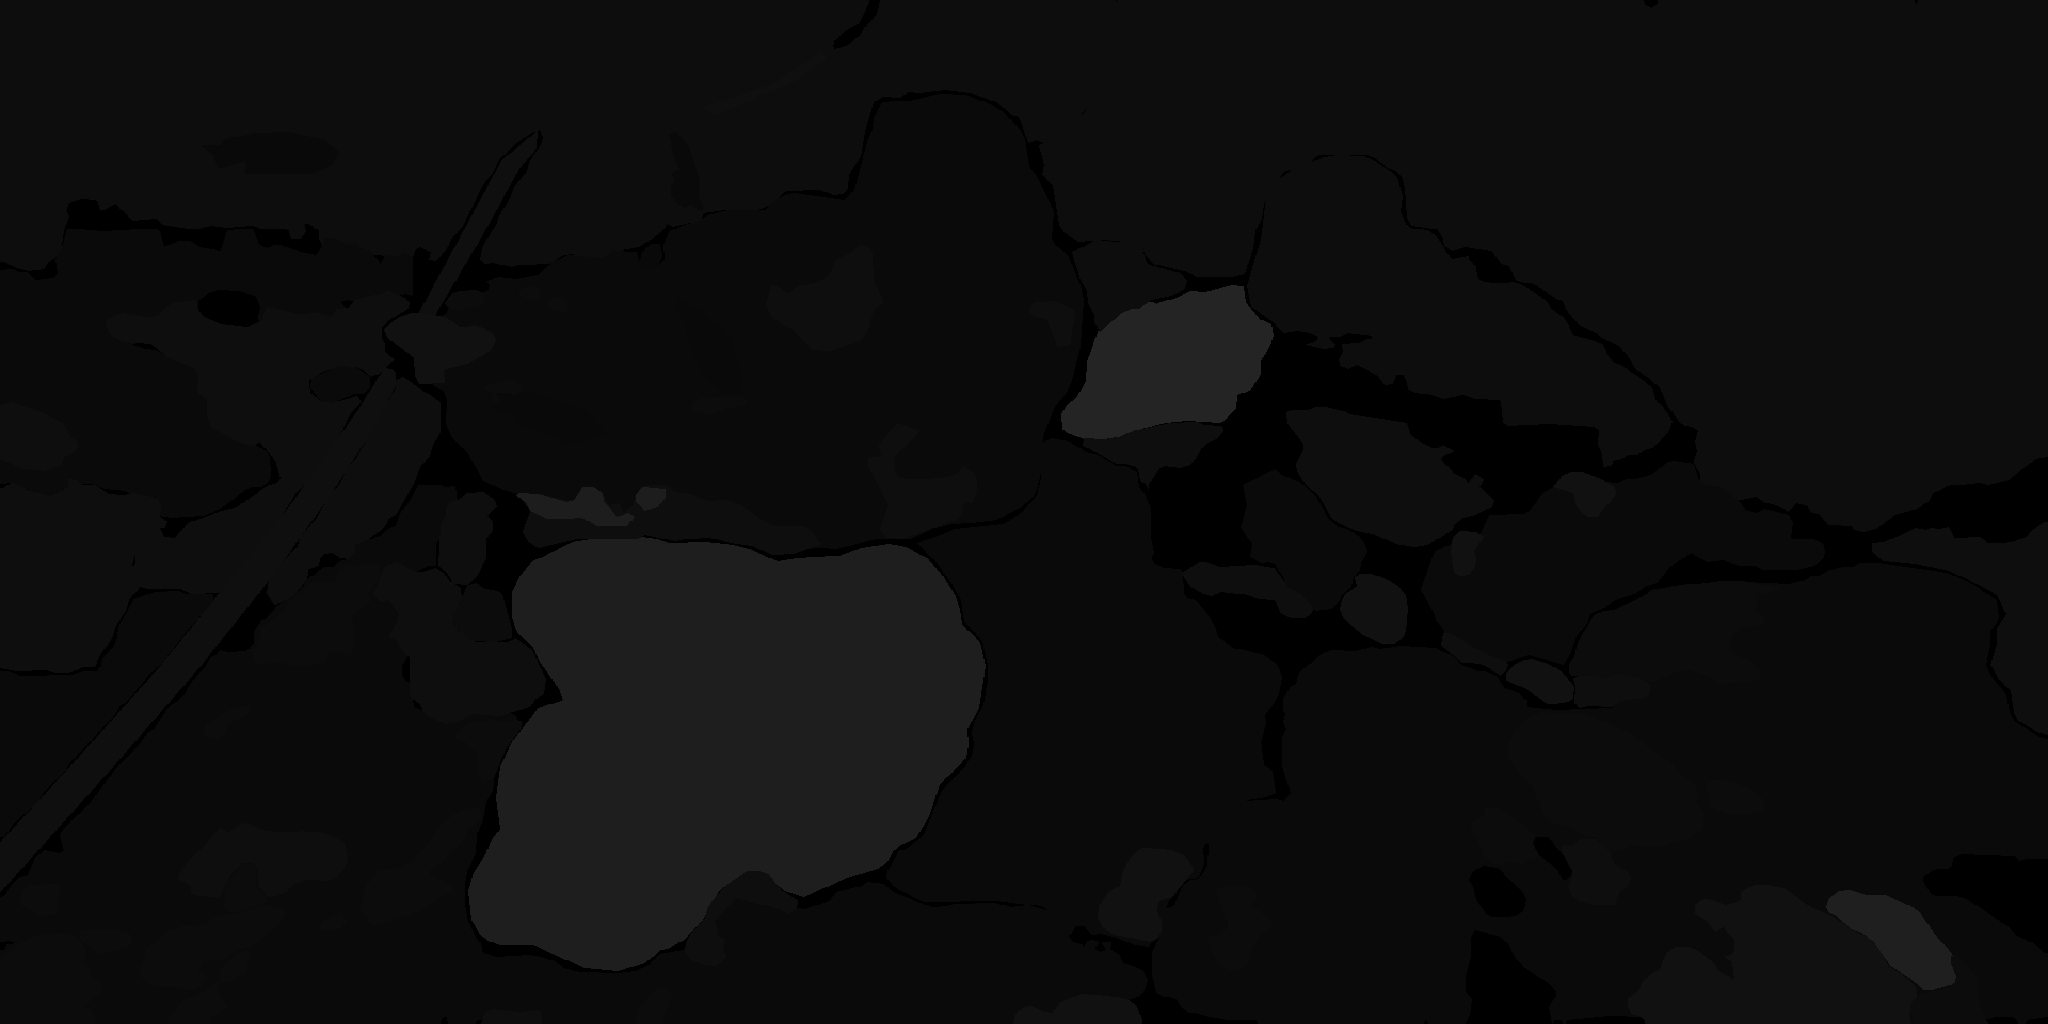

(1024, 2048)


In [10]:
from IPython.display import display
sample = ds['train'][0]
image = sample['image']
mask = sample['label']
display(mask)
print(np.shape(mask))

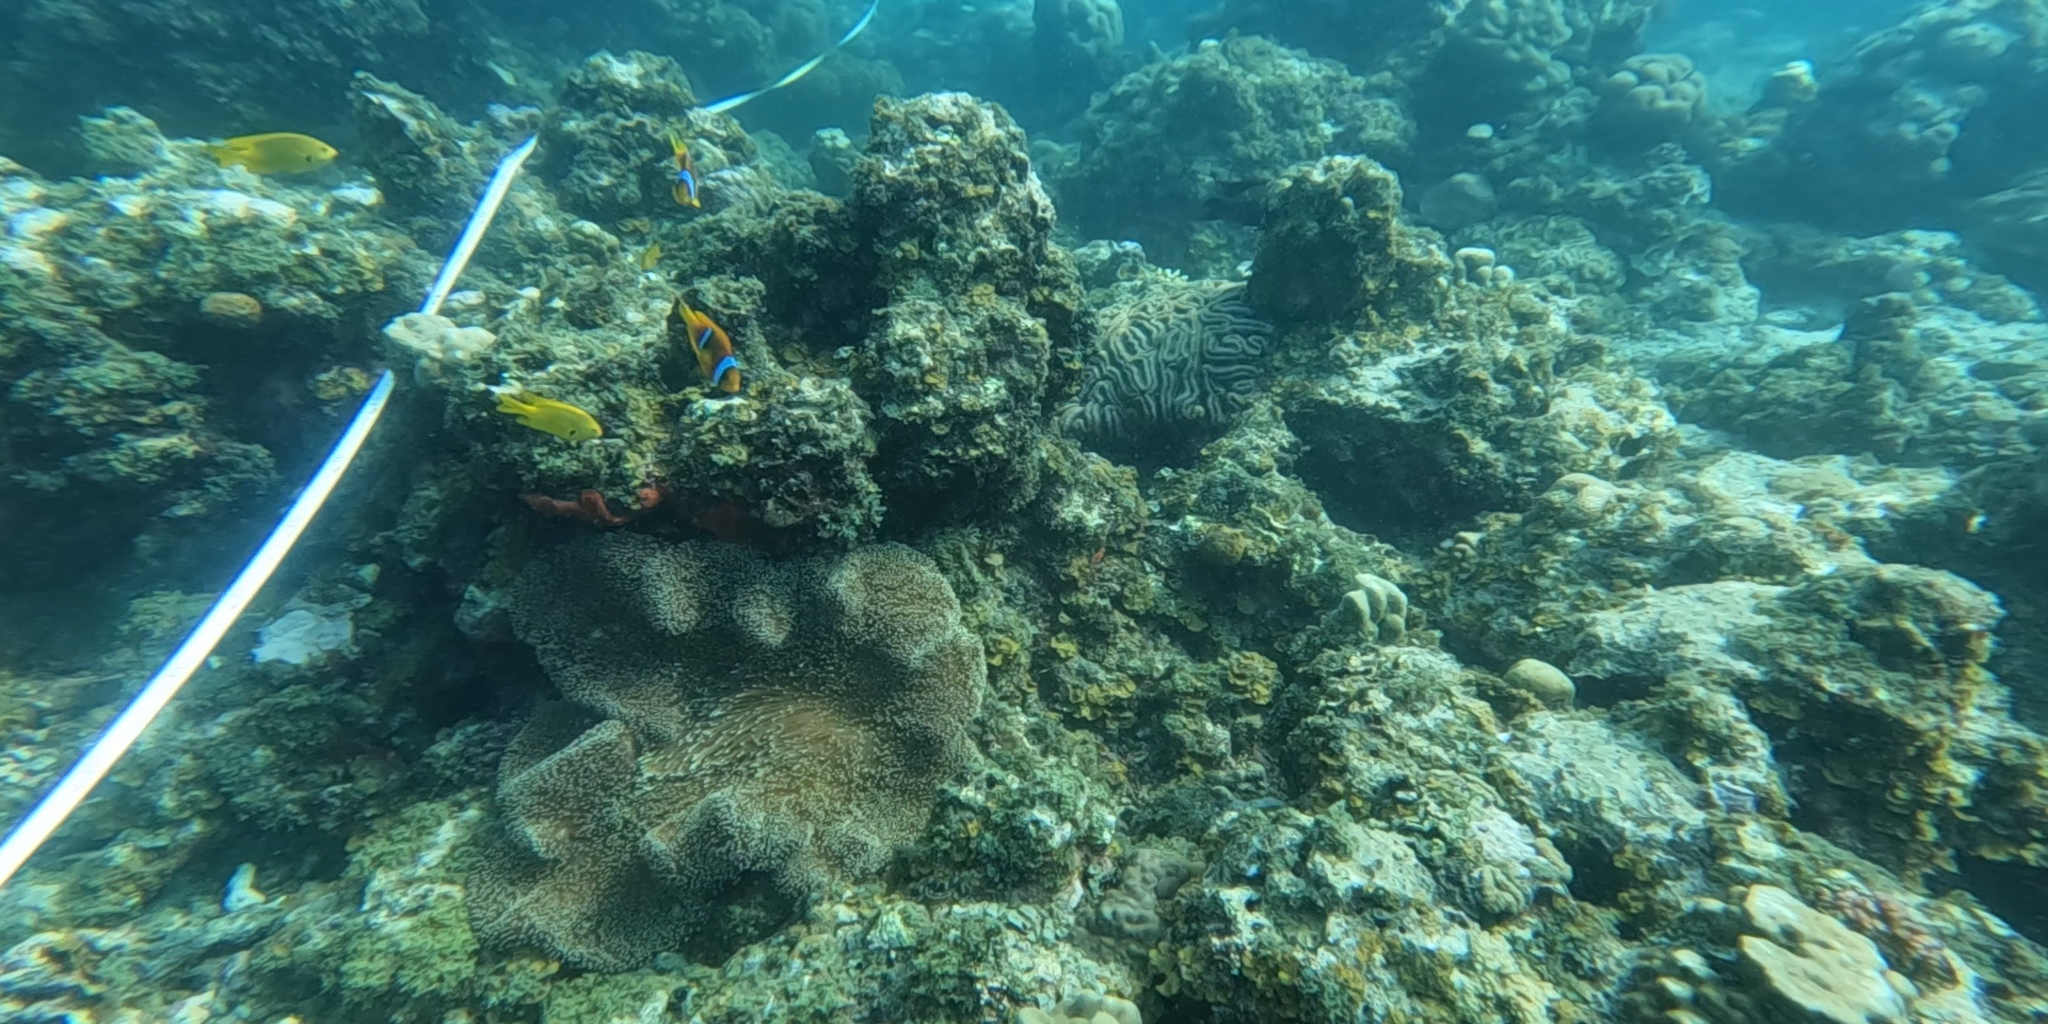

In [11]:
display(image)

In [12]:
from collections import namedtuple

Label = namedtuple('Label', [
    'name',
    'id',
    'trainId',
    'category',
    'categoryId',
    'hasInstances',
    'ignoreInEval',
    'color',
])

# Category mapping (custom, feel free to adjust)
category_map = {
    'coral': 0,
    'animal': 1,
    'substrate': 2,
    'human': 3,
    'object': 4,
    'plant': 5,
    'trash': 6,
    'unknown': 7,
    'void': 8
}

labels = [
    #              name                       id  trainId  category           categoryId  hasInstances  ignoreInEval  color
    Label('unlabeled',                        0,     255,  'void',            category_map['void'],     False,       True,   (255, 255, 255)),
    Label('seagrass',                         1,       0,  'plant',           category_map['plant'],    False,       False,  (125, 222, 125)),
    Label('trash',                            2,       1,  'trash',           category_map['trash'],    False,       False,  (255, 0, 134)),
    Label('other coral dead',                 3,       2,  'coral',           category_map['coral'],    False,       False,  (114, 60, 61)),
    Label('other coral bleached',             4,       3,  'coral',           category_map['coral'],    False,       False,  (250, 224, 225)),
    Label('sand',                             5,       4,  'substrate',       category_map['substrate'],False,       False,  (194, 178, 128)),
    Label('other coral alive',                6,       5,  'coral',           category_map['coral'],    False,       False,  (224, 118, 119)),
    Label('human',                            7,       6,  'human',           category_map['human'],    True,        False,  (255, 0, 0)),
    Label('transect tools',                   8,       7,  'object',          category_map['object'],   False,       False,  (8, 205, 12)),
    Label('fish',                             9,       8,  'animal',          category_map['animal'],   True,        False,  (255, 255, 0)),
    Label('algae covered substrate',         10,       9,  'substrate',       category_map['substrate'],False,       False,  (125, 163, 125)),
    Label('other animal',                    11,      10,  'animal',          category_map['animal'],   False,       False,  (0, 255, 255)),
    Label('unknown hard substrate',          12,      11,  'unknown',         category_map['unknown'],  False,       False,  (125, 125, 125)),
    Label('background',                      13,      255, 'void',            category_map['void'],     False,       True,   (29, 162, 216)),
    Label('dark',                            14,      255, 'void',            category_map['void'],     False,       True,   (31, 31, 31)),
    Label('transect line',                   15,      12,  'object',          category_map['object'],   False,       False,  (0, 255, 0)),
    Label('massive/meandering bleached',     16,      13,  'coral',           category_map['coral'],    False,       False,  (255, 248, 228)),
    Label('massive/meandering alive',        17,      14,  'coral',           category_map['coral'],    False,       False,  (236, 150, 21)),
    Label('rubble',                          18,      15,  'substrate',       category_map['substrate'],False,       False,  (161, 153, 128)),
    Label('branching bleached',             19,      16,  'coral',           category_map['coral'],    False,       False,  (252, 231, 240)),
    Label('branching dead',                 20,      17,  'coral',           category_map['coral'],    False,       False,  (123, 50, 86)),
    Label('millepora',                       21,      18,  'coral',           category_map['coral'],    False,       False,  (244, 150, 115)),
    Label('branching alive',                22,      19,  'coral',           category_map['coral'],    False,       False,  (226, 91, 157)),
    Label('massive/meandering dead',        23,      20,  'coral',           category_map['coral'],    False,       False,  (134, 86, 18)),
    Label('clam',                            24,      21,  'animal',          category_map['animal'],   False,       False,  (189, 255, 234)),
    Label('acropora alive',                  25,      22,  'coral',           category_map['coral'],    False,       False,  (236, 128, 255)),
    Label('sea cucumber',                    26,      23,  'animal',          category_map['animal'],   False,       False,  (0, 231, 255)),
    Label('turbinaria',                      27,      24,  'coral',           category_map['coral'],    False,       False,  (228, 255, 119)),
    Label('table acropora alive',            28,      25,  'coral',           category_map['coral'],    False,       False,  (189, 119, 255)),
    Label('sponge',                          29,      26,  'animal',          category_map['animal'],   False,       False,  (240, 80, 80)),
    Label('anemone',                         30,      27,  'animal',          category_map['animal'],   False,       False,  (0, 255, 189)),
    Label('pocillopora alive',              31,      28,  'coral',           category_map['coral'],    False,       False,  (255, 146, 150)),
    Label('table acropora dead',            32,      29,  'coral',           category_map['coral'],    False,       False,  (85, 53, 116)),
    Label('meandering bleached',            33,      30,  'coral',           category_map['coral'],    False,       False,  (251, 243, 216)),
    Label('stylophora alive',               34,      31,  'coral',           category_map['coral'],    False,       False,  (255, 111, 194)),
    Label('sea urchin',                      35,      32,  'animal',          category_map['animal'],   False,       False,  (0, 142, 255)),
    Label('meandering alive',               36,      33,  'coral',           category_map['coral'],    False,       False,  (230, 193, 0)),
    Label('meandering dead',                37,      34,  'coral',           category_map['coral'],    False,       False,  (119, 100, 14)),
    Label('crown of thorn',                 38,      35,  'animal',          category_map['animal'],   False,       False,  (179, 245, 234)),
    Label('dead clam',                       39,      36,  'animal',          category_map['animal'],   False,       False,  (89, 155, 134)),
]


In [61]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Works on PIL Image
    transforms.ToTensor(),          # Converts to tensor after resizing
])

In [62]:
class Cityscape(Dataset):
    def __init__(self, dcit, transform=transform, label_map='id',operation='train'):
        self.transform = transform
        self.ds = dcit
        self.label_map = label_map
        self.dataset_ops = operation
        self.id_2_train = {}
        self.id_2_cat = {}
        self.trainid_2_name = {}
        self.train_2_id = {}
        self.id_2_name = {}

        for lbl in labels:
            self.id_2_train[lbl.id] = 0 if lbl.ignoreInEval else lbl.trainId
            self.id_2_cat[lbl.id] = lbl.categoryId
            if not lbl.ignoreInEval:
                self.trainid_2_name[lbl.trainId] = lbl.name
                self.train_2_id[lbl.trainId] = lbl.id
            self.id_2_name[lbl.id] = lbl.name

    def __getitem__(self, idx):
        sample = self.ds[self.dataset_ops][idx]
        img = sample['image']
        mask = np.array(sample['label']).astype(np.float32)

        if self.label_map == 'id':
            mask[mask == -1] = 0  # Default ignore
        elif self.label_map == 'trainId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, train_id in self.id_2_train.items():
                mapped_mask[mask == _id] = train_id
            mask = mapped_mask
        elif self.label_map == 'categoryId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, cat_id in self.id_2_cat.items():
                mapped_mask[mask == _id] = cat_id
            mask = mapped_mask
        mask = Image.fromarray(mask)
        mask = mask.resize((256, 256), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()  # convert back to tensor
        # Apply transforms
        if self.transform:
            img = self.transform(img) # Apply transform to image and update img

        return img, mask

    def __len__(self):
        return len(self.ds[self.dataset_ops]) # Corrected to use self.dataset_ops


In [103]:
dataset = Cityscape(ds,  transform=transform,operation='train')
data_loader = DataLoader(dataset, batch_size=32, shuffle=True,drop_last=True )

In [104]:
try:
    images, masks = next(iter(data_loader))

    print(f"Shape of images in the first batch: {images.shape}")
    print(f"Shape of masks in the first batch: {masks.shape}")
    if images.shape[0] == 4:
        print("Success: The first batch contains 4 images.")
    else:
        print(f"Warning: The first batch contains {images.shape[0]} images, not 4.")
        print("This could happen if drop_last=True was not used and the dataset size is small.")

except StopIteration:
    print("Error: The DataLoader is empty. This can happen if the dataset is too small for the batch size and drop_last=True.")
    print(f"Dataset length: {len(dataset)}")

Shape of images in the first batch: torch.Size([32, 3, 256, 256])
Shape of masks in the first batch: torch.Size([32, 256, 256])
This could happen if drop_last=True was not used and the dataset size is small.


In [105]:
for batch_idx, (images, masks) in enumerate(tqdm(data_loader, desc="Checking batches")):
    current_batch_size = images.shape[0]
    if current_batch_size != 4:
        print(f"\nIssue found in batch {batch_idx}: Expected 32 images, got {current_batch_size} images.")
        break
    else:
        if batch_idx < 3: 
            print(f"Batch {batch_idx} images shape: {images.shape}")
            print(f"Batch {batch_idx} masks shape: {masks.shape}")

print("\nVerification complete. All batches (if drop_last=True) should be 32 images, or the last batch will be smaller if drop_last=False.")


Checking batches:   0%|                                  | 0/47 [00:01<?, ?it/s]


Issue found in batch 0: Expected 32 images, got 32 images.

Verification complete. All batches (if drop_last=True) should be 32 images, or the last batch will be smaller if drop_last=False.


In [106]:
img,label = next(iter(data_loader))
img_np = img[0].cpu().numpy() 
print(np.shape(img))

torch.Size([32, 3, 256, 256])


torch.Size([32, 256, 256])


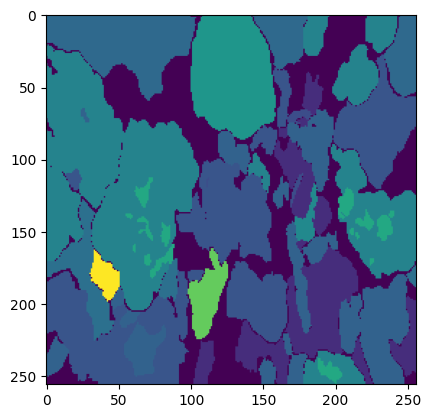

In [107]:
img_np = img[3].cpu().numpy() 
print(np.shape(label))
img_np = img[0].cpu().numpy()
np.shape(label[1])
label_np = label[1].cpu().numpy() 
plt.imshow(label_np)
img_np = np.transpose(img_np, (1, 2, 0))



In [108]:
print("First 5 ID to TrainID mappings:", list(dataset.id_2_train.items())[:40])
print("TrainID to Name:", dataset.trainid_2_name)
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

First 5 ID to TrainID mappings: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 0), (14, 0), (15, 12), (16, 13), (17, 14), (18, 15), (19, 16), (20, 17), (21, 18), (22, 19), (23, 20), (24, 21), (25, 22), (26, 23), (27, 24), (28, 25), (29, 26), (30, 27), (31, 28), (32, 29), (33, 30), (34, 31), (35, 32), (36, 33), (37, 34), (38, 35), (39, 36)]
TrainID to Name: {0: 'seagrass', 1: 'trash', 2: 'other coral dead', 3: 'other coral bleached', 4: 'sand', 5: 'other coral alive', 6: 'human', 7: 'transect tools', 8: 'fish', 9: 'algae covered substrate', 10: 'other animal', 11: 'unknown hard substrate', 12: 'transect line', 13: 'massive/meandering bleached', 14: 'massive/meandering alive', 15: 'rubble', 16: 'branching bleached', 17: 'branching dead', 18: 'millepora', 19: 'branching alive', 20: 'massive/meandering dead', 21: 'clam', 22: 'acropora alive', 23: 'sea cucumber', 24: 'turbinaria', 25: 'table acropora alive', 26: 'sponge', 2

In [109]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1202 MiB |   2211 MiB |  25052 GiB |  25051 GiB |
|       from large pool |   1079 MiB |   2105 MiB |  24986 GiB |  24985 GiB |
|       from small pool |    122 MiB |    140 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1202 MiB |   2211 MiB |  25052 GiB |  25051 GiB |
|       from large pool |   1079 MiB |   2105 MiB |  24986 GiB |

In [122]:
dir_path = "/media/adminnio/Volume/Data/Datasets/Corals/models/weights"
model_name = "deeplabv3_resnet50_coral_segmentation" # A descriptive name for your model
model_save_dir = os.path.join(dir_path, model_name)
os.makedirs(model_save_dir, exist_ok=True) # Create the directory if it doesn't exist
log_file_path = os.path.join(model_save_dir, f"{model_name}_training_log.csv")
log_data = [] # To store loss and IoU for each epoch

best_iou = -1.0 # Initialize best IoU for saving the best model


In [124]:
def calculate_iou(outputs, masks, num_classes):
    # outputs: (N, C, H, W) - raw model outputs
    # masks: (N, H, W) - ground truth masks
    preds = torch.argmax(outputs, dim=1) # Get predicted class for each pixel

    iou_per_class = []
    for cls in range(num_classes):
        true_positive = ((preds == cls) & (masks == cls)).sum().item()
        false_positive = ((preds == cls) & (masks != cls)).sum().item()
        false_negative = ((preds != cls) & (masks == cls)).sum().item()

        denominator = true_positive + false_positive + false_negative
        if denominator == 0:
            iou_per_class.append(np.nan) # Avoid division by zero
        else:
            iou_per_class.append(true_positive / denominator)

    # Filter out NaN values (classes not present in current batch)
    valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
    if len(valid_ious) == 0:
        return 0.0 # No valid classes to compute IoU
    return np.mean(valid_ious)

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

torch.cuda.empty_cache()
model = deeplabv3_resnet50(pretrained=True)
from torchvision.models.segmentation import fcn_resnet50
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 40, 1)
# for param in model.backbone.parameters(): #fREEZE BACKBONE
#     param.requires_grad = False
model.to(device)
epochs=200
verbose =1
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore unlabeled pixels if you use -1
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    running_iou = 0.0
    total_batches = len(data_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 30)

    progress_bar = tqdm(enumerate(data_loader), total=total_batches, leave=False)
    for batch_idx, (images, masks) in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs['out'], masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate IoU for the current batch
        # Assuming your model outputs 40 classes (as per model.classifier[4] = torch.nn.Conv2d(256, 40, 1))
        batch_iou = calculate_iou(outputs['out'], masks, num_classes=40)
        running_iou += batch_iou


        avg_loss = running_loss / (batch_idx + 1)
        avg_iou = running_iou / (batch_idx + 1)

        progress_bar.set_description(f"Batch {batch_idx+1}/{total_batches}")
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}", iou=f"{avg_iou:.4f}")

    epoch_loss = running_loss / total_batches
    epoch_iou = running_iou / total_batches
    print(f"Epoch {epoch+1} finished. Average Loss: {epoch_loss:.4f}, Average IoU: {epoch_iou:.4f}")

    # --- Save Checkpoint ---
    # Save the model state and optimizer state
    checkpoint_path = os.path.join(model_save_dir, f"{model_name}_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'iou': epoch_iou,
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

    # Save the best model based on IoU
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_model_path = os.path.join(model_save_dir, f"{model_name}_best_iou.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with IoU: {best_iou:.4f}")

    # --- Log Data to CSV ---
    log_data.append({
        'epoch': epoch + 1,
        'loss': epoch_loss,
        'iou': epoch_iou
    })
    pd.DataFrame(log_data).to_csv(log_file_path, index=False)
    print(f"Training log updated at {log_file_path}")

print("\nTraining complete!")


Epoch 1/200
------------------------------


Epoch 1 finished. Average Loss: 2.2422, Average IoU: 0.0530
Checkpoint saved to /media/adminnio/Volume/Data/Datasets/Corals/models/weights/deeplabv3_resnet50_coral_segmentation/deeplabv3_resnet50_coral_segmentation_epoch_1.pth
Training log updated at /media/adminnio/Volume/Data/Datasets/Corals/models/weights/deeplabv3_resnet50_coral_segmentation/deeplabv3_resnet50_coral_segmentation_training_log.csv

Epoch 2/200
------------------------------


Batch 9/47:  19%|█▎     | 9/47 [00:17<01:12,  1.92s/it, iou=0.0779, loss=1.8119]

In [111]:
dir_path = "/media/adminnio/Volume/Data/Datasets/Corals/models/weights"
os.makedirs(dir_path, exist_ok=True) 
PATH = os.path.join(dir_path, "model_weights_deeplabv3_resnet50_50epochs.pth")
torch.save(model.state_dict(), PATH)


In [114]:
!ls /media/adminnio/Volume/Data_NerfRaw/Lakshwadeep/data_backup_manikandansir/DCIM/Lagoon/K.L1/Tag_1/G0029465.JPG

'Tag 1'  'Tag 2'  'Tag 3'


In [117]:
num_classes = 40 
color_map = np.zeros((num_classes, 3), dtype=np.uint8)
for label in labels:
    if label.trainId != 255:
        color_map[label.trainId] = label.color
img_path = "/media/adminnio/Volume/Data_NerfRaw/Lakshwadeep/data_backup_manikandansir/DCIM/Lagoon/K.L1/Tag_1/G0029465.JPG"
img_pil = Image.open(img_path).convert("RGB")

import torchvision.transforms as T
transform = T.Compose([
    T.Resize((256, 267)),
    T.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
img_tensor = transform(img_pil).unsqueeze(0).to(device)  # (1, C, H, W)

with torch.no_grad():
    output = model(img_tensor)  # Output shape: [1, num_classes, H, W]

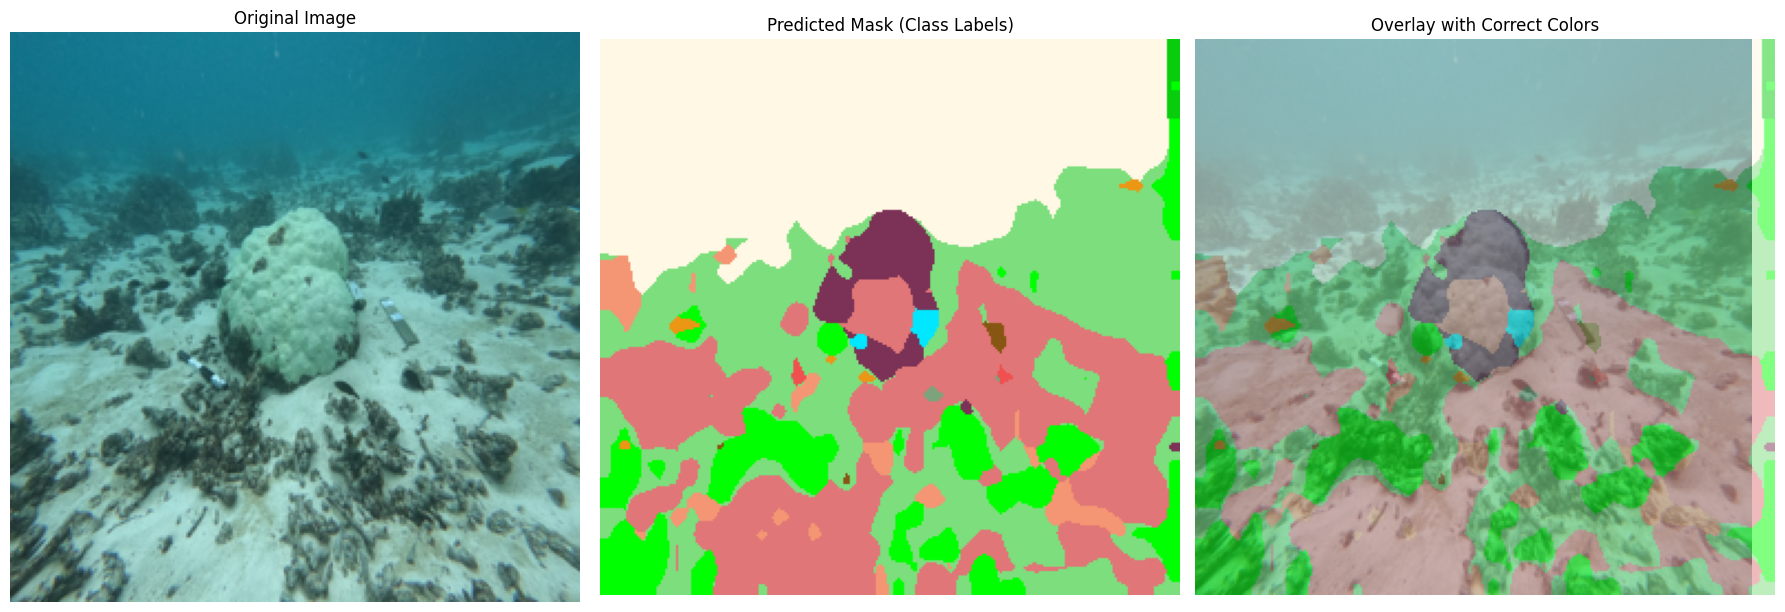

In [120]:



class_map = torch.argmax(output['out'].squeeze(0), dim=0).cpu().numpy()  # (H, W)
color_mask = color_map[class_map]  # (H, W, 3) uint8
color_mask_norm = color_mask.astype(np.float32) / 255.0
img_resized = img_pil.resize((256, 256))
img_np = np.array(img_resized).astype(np.float32) / 255.0
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[1].imshow(color_mask_norm,  vmin=0, vmax=num_classes-1)
axs[1].set_title("Predicted Mask (Class Labels)")
axs[2].imshow(img_np)
axs[2].imshow(color_mask_norm, alpha=0.5)
axs[2].set_title("Overlay with Correct Colors")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()